In [162]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

In [163]:
# Geometry
L = 0.43 # m, reactor length
dz = 0.001 # m, grid size
n_nodes = int(L/dz) + 1 # number of grid points
z = np.linspace(0, L, n_nodes) # grid points

ID = 5.03e-3 # m, inner diameter
OD = 6.33e-3 # m, outer diameter
tkn = OD - ID # m, wall thickness

Ai = np.pi * ID**2 / 4 # m2, inner cross-sectional area
Ao = np.pi * OD**2 / 4 # m2, outer cross-sectional area
Aw = Ao - Ai # m2, wall cross-sectional area

pri = np.pi * ID # m, inner perimeter
pro = np.pi * OD # m, outer perimeter

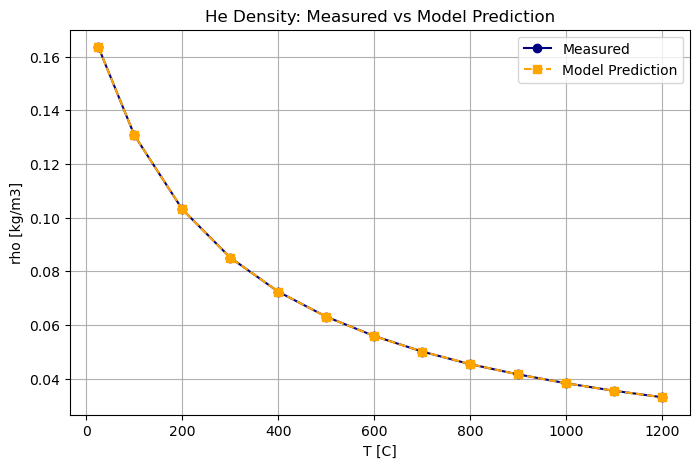

Text(0.5, 1.0, 'KanthalD Heat Capacity: Measured vs Model Prediction')

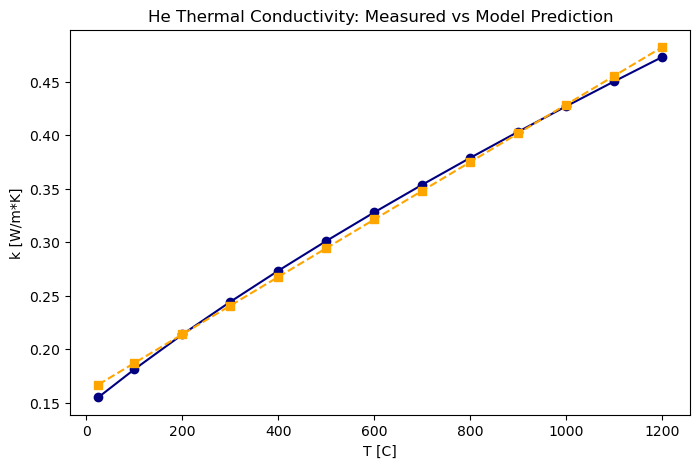

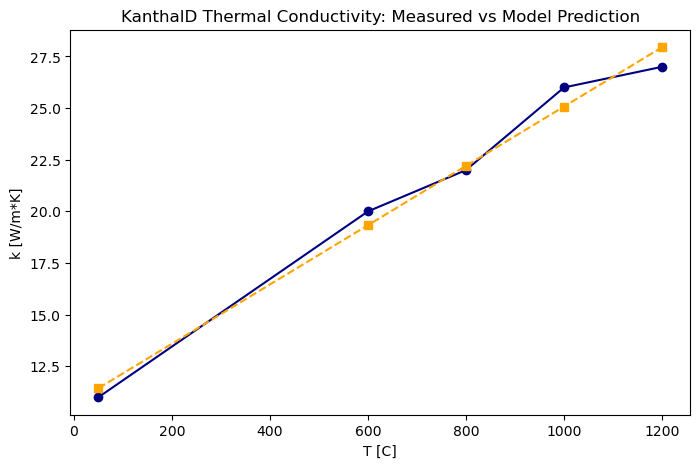

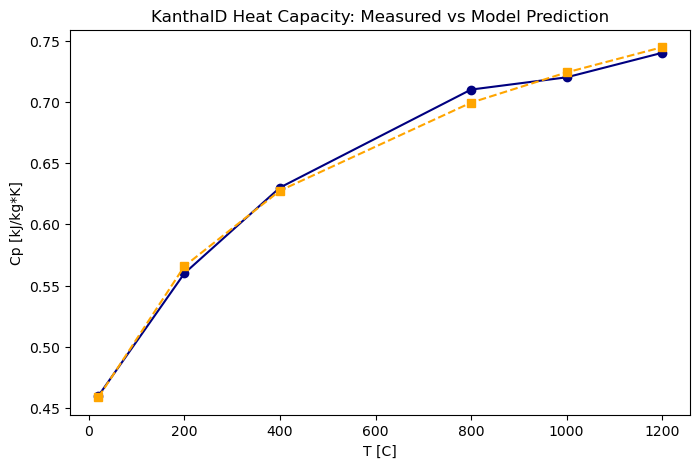

In [164]:
# Material properties
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he)
df_kt = pd.read_csv(path_kt)

# He molar weight
Mw_he = 4.0026 # g/mol

# He density
def rho_he_fit(T, a, b, c):
    return a / (b + T) + c
prho_he, _ = curve_fit(rho_he_fit, df_he['T [C]'], df_he['rho [kg/m3]'])
a_rho_he, b_rho_he, c_rho_he = prho_he
def rho_he(T):
    return a_rho_he / (b_rho_he + T) + c_rho_he
fitted_rho = rho_he(df_he['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_he['T [C]'], df_he['rho [kg/m3]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_he['T [C]'], fitted_rho, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('rho [kg/m3]')
plt.title('He Density: Measured vs Model Prediction')
plt.legend()
plt.grid(True)
plt.show()

# He heat capacity
Cp_he = 20.786 # J/mol/K, heat capacity of helium

# He thermal conductivity
def k_he_fit(T, a, b):
    return a*T + b
pk_he, _ = curve_fit(k_he_fit, df_he['T [C]'], df_he['Tc [W/m*K]'])
a_k_he, b_k_he = pk_he
def k_he(T):
    return a_k_he*T + b_k_he
fitted_k = k_he(df_he['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_he['T [C]'], df_he['Tc [W/m*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_he['T [C]'], fitted_k, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('k [W/m*K]')
plt.title('He Thermal Conductivity: Measured vs Model Prediction')

# kanthalD density
rho_kt = 7250 # kg/m3

# kanthalD thermal conductivity
def k_kt_fit(T, a, b):
    return a*T + b
df_kt_k = df_kt[df_kt['k [W/m*K]'].notna()]
pk_kt, _ = curve_fit(k_kt_fit, df_kt_k['T [C]'], df_kt_k['k [W/m*K]'])
a_k_kt, b_k_kt = pk_kt
def k_kt(T):
    return a_k_kt*T + b_k_kt
fitted_k_kt = k_kt(df_kt_k['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_kt_k['T [C]'], df_kt_k['k [W/m*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_kt_k['T [C]'], fitted_k_kt, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('k [W/m*K]')
plt.title('KanthalD Thermal Conductivity: Measured vs Model Prediction')

# kanthalD heat capacity
def Cp_kt_fit(T, a, b, c):
    return a*np.log(T + b) + c
df_kt_Cp = df_kt[df_kt['Cp [kJ/kg*K]'].notna()]
pk_kt, _ = curve_fit(Cp_kt_fit, df_kt_Cp['T [C]'], df_kt_Cp['Cp [kJ/kg*K]'])
a_Cp_kt, b_Cp_kt, c_Cp_kt = pk_kt
def Cp_kt(T):
    return (a_Cp_kt*np.log(T + b_Cp_kt) + c_Cp_kt) # kJ/kg/K
fitted_Cp_kt = Cp_kt(df_kt_Cp['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_kt_Cp['T [C]'], df_kt_Cp['Cp [kJ/kg*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_kt_Cp['T [C]'], fitted_Cp_kt, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('Cp [kJ/kg*K]')
plt.title('KanthalD Heat Capacity: Measured vs Model Prediction')

In [165]:
# Feed conditions
Fv_std = 50 # mL/min at standard conditions
Fw = Fv_std * 1e-6 / 60 * rho_he(0) # kg/s, feed mass flow rate
F = Fw / Mw_he * 1000 # mol/s, feed molar flow rate
P = 101325 # Pa, feed pressure
Ti = 25 # C, feed temperature
Tamb = 25 # C, ambient temperature
Pw = 140 # W, electric power

# Boundary heat transfer coefficients (to be optimized)
h_wall_inlet = 10   # W/m2/K, wall boundary heat transfer at inlet
h_wall_outlet = 10  # W/m2/K, wall boundary heat transfer at outlet
h_gas_inlet = 20    # W/m2/K, gas boundary heat transfer at inlet
h_gas_outlet = 20   # W/m2/K, gas boundary heat transfer at outlet

In [166]:
# rhs function (pure function without side effects)
def rhs(t, y):
    '''
    y = [Tw(431), Tg(431)]
    
    Boundary conditions:
    - Interior nodes (1:-1): Full physics (Qelec, Qwg, Qloss, Qcond for wall, Qadv for gas)
    - Boundary nodes (0, -1): Physics EXCEPT axial conduction/advection + boundary heat exchange
    
    Rationale: Boundary nodes are part of the physical tube (so have Qelec, Qwg, Qloss),
               but axial conduction is excluded. Additional boundary heat exchange (h coefficients)
               accounts for exposed regions outside insulated 430mm zone.
               
    Sign convention for boundary heat exchange:
    - Q_boundary = h * A * (T - Tamb)
    - Positive Q_boundary = heat loss (T > Tamb)
    - Negative Q_boundary = heat gain (T < Tamb)
    - In ODE: subtract Q_boundary (acts as additional heat loss)
    '''
    Tw = y[:n_nodes]
    Tg = y[n_nodes:]

    # heat exchange area
    Awg = pri * dz # m2, wall-gas contact area
    Aout = pro * dz # m2, outer surface area (per node)

    # heat transfer coefficient for wall-gas heat transfer
    hwg = 4.36*k_he(Tg)/ID

    # heat transfer coefficient for outside heat loss
    hout = 1 # W/m2/K

    # electric heating (uniform) - ALL NODES
    Qelec = Pw / n_nodes * np.ones(n_nodes)

    # === Wall axial conduction (INTERIOR NODES ONLY) ===
    Qcond = np.zeros(n_nodes)
    
    # Compute conduction only for interior nodes (1:-1)
    Tw_pad = np.pad(Tw, (1, 1), mode='edge')
    d2Tw = (Tw_pad[2:] - 2*Tw_pad[1:-1] + Tw_pad[:-2]) / dz**2
    Qcond = k_kt(Tw) * Aw * d2Tw * dz  # W

    # wall-gas heat transfer - ALL NODES
    Qwg = hwg * Awg * (Tw - Tg)  # W

    # outside heat loss (radial) - ALL NODES
    Qloss = hout * Aout * (Tw - Tamb)

    # === Wall temperature rate calculation ===
    dTw = np.zeros(n_nodes)

    # INTERIOR NODES (1:-1): Full physics including conduction
    if n_nodes > 2:
        dTw[1:-1] = (Qelec[1:-1] - Qwg[1:-1] - Qloss[1:-1] + Qcond[1:-1]) / (Cp_kt(Tw[1:-1])*1000 * rho_kt * Aw * dz)

    # BOUNDARY NODES (0, -1): Physics EXCEPT conduction + boundary exchange
    # Inlet boundary
    Q_wall_boundary_inlet = h_wall_inlet * Aw * (Tw[0] - Tamb)  # W, positive = heat loss
    dTw[0] = (Qelec[0] - Qwg[0] - Qloss[0] - Q_wall_boundary_inlet + Qcond[0]) / (Cp_kt(Tw[0])*1000 * rho_kt * Aw * dz)

    # Outlet boundary
    Q_wall_boundary_outlet = h_wall_outlet * Aw * (Tw[-1] - Tamb)  # W, positive = heat loss
    dTw[-1] = (Qelec[-1] - Qwg[-1] - Qloss[-1] - Q_wall_boundary_outlet + Qcond[-1]) / (Cp_kt(Tw[-1])*1000 * rho_kt * Aw * dz)

    # === Gas advection ===
    Qadv = np.zeros(n_nodes)

    # Interior and outlet nodes (1:): advection from upstream
    if n_nodes > 1:
        Qadv[1:] = F * Cp_he * (Tg[:-1] - Tg[1:])  # W

    # Inlet node (0): NO advection (no upstream)

    # === Gas temperature rate calculation ===
    dTg = np.zeros(n_nodes)

    # INTERIOR NODES (1:-1): Advection and wall-gas heat transfer
    if n_nodes > 2:
        dTg[1:-1] = (Qadv[1:-1] + Qwg[1:-1]) / (Cp_he * rho_he(Tg[1:-1]) * Ai * dz)

    # BOUNDARY NODES (0, -1): Wall-gas transfer + boundary exchange
    # Inlet boundary (no advection)
    Q_gas_boundary_inlet = h_gas_inlet * Ai * (Tg[0] - Tamb)  # W, positive = heat loss
    dTg[0] = (Qwg[0] - Q_gas_boundary_inlet) / (Cp_he * rho_he(Tg[0]) * Ai * dz)

    # Outlet boundary (has advection from upstream)
    Q_gas_boundary_outlet = h_gas_outlet * Ai * (Tg[-1] - Tamb)  # W, positive = heat loss
    dTg[-1] = (Qadv[-1] + Qwg[-1] - Q_gas_boundary_outlet) / (Cp_he * rho_he(Tg[-1]) * Ai * dz)

    return np.concatenate([dTw, dTg])


# Energy flux calculation function (for post-processing)
def calculate_energy_fluxes(t, y):
    '''
    Calculate instantaneous energy fluxes at system boundaries
    
    Energy balance: 
    dH/dt = Q_in(electric) - Q_out(advection) - Q_loss(radial) - Q_boundary_loss
    
    Sign convention:
    - All heat losses are POSITIVE (heat leaving the system)
    - Q_boundary = h * A * (T - Tamb), positive when T > Tamb (heat loss)
    
    Note: 
    - Electric power distributed to ALL nodes
    - Radial loss from ALL nodes
    - No Q_cond_net because conduction only in interior
    - Boundary heat exchange = additional heat loss from exposed regions
    
    Returns: Q_in, Q_out_advection, Q_loss, Q_boundary_loss (all in Watts)
    '''
    Tw = y[:n_nodes]
    Tg = y[n_nodes:]
    
    # Heat exchange area
    Aout = pro * dz # m2, outer surface area
    hout = 1# W/m2/K
    
    # 1. Electric power input (all nodes)
    Q_in = Pw  # W
    
    # 2. Advection outflow (net enthalpy change due to flow)
    Q_out_advection = F * Cp_he * (Tg[-1] - Tg[0])  # W
    
    # 3. External heat loss (radial, all nodes)
    Q_loss = np.sum(hout * Aout * (Tw - Tamb))  # W
    
    # 4. Boundary heat exchange (inlet/outlet) - all are LOSSES
    # Wall boundaries (represents exposed regions outside insulated zone)
    Q_wall_inlet = h_wall_inlet * Aw * (Tw[0] - Tamb)      # W, positive = heat loss
    Q_wall_outlet = h_wall_outlet * Aw * (Tw[-1] - Tamb)   # W, positive = heat loss
    
    # Gas boundaries
    Q_gas_inlet = h_gas_inlet * Ai * (Tg[0] - Tamb)        # W, positive = heat loss
    Q_gas_outlet = h_gas_outlet * Ai * (Tg[-1] - Tamb)     # W, positive = heat loss
    
    Q_boundary_loss = Q_wall_inlet + Q_wall_outlet + Q_gas_inlet + Q_gas_outlet  # Total boundary loss
    
    return Q_in, Q_out_advection, Q_loss, Q_boundary_loss


# Enthalpy calculation function (for post-processing)
def calculate_system_enthalpy(y):
    '''
    Calculate total system enthalpy at given state (Tamb reference)
    
    For open systems with flow:
    - Gas: Use enthalpy H = Σ [n * Cp * (T - Tref)]
    - Wall: Use internal energy U ≈ Σ [m * Cp * (T - Tref)] (solid: Cp ≈ Cv)
    
    Returns: H_wall, H_gas, H_total (all in Joules)
    '''
    Tw = y[:n_nodes]
    Tg = y[n_nodes:]
    
    # Wall internal energy (reference: Tamb = 25C)
    H_wall = np.sum(rho_kt * Aw * dz * Cp_kt(Tw) * 1000 * (Tw - Tamb))  # J
    
    # Gas enthalpy (reference: Tamb = 25C)
    # H = Σ [ρ * V / M * Cp * (T - Tref)] = Σ [ρ * V * Cp_mass * (T - Tref)]
    H_gas = np.sum(rho_he(Tg) * Ai * dz * (Cp_he / Mw_he * 1000) * (Tg - Tamb))  # J
    
    H_total = H_wall + H_gas
    
    return H_wall, H_gas, H_total

In [167]:
tend = 20000
t_span = (0, tend)
t_eval = np.linspace(*t_span, tend+1)

Tw0 = np.full(n_nodes, 25)
Tg0 = np.full(n_nodes, 25)
y0 = np.concatenate([Tw0, Tg0])

sol = solve_ivp(
    fun = lambda t, y: rhs(t, y),
    t_span = t_span,
    y0 = y0,
    method = 'BDF',
    t_eval = t_eval,
    rtol = 1e-6,
    atol = 1e-6
)

assert sol.success

Tw = sol.y[:n_nodes, :]
Tg = sol.y[n_nodes:, :]

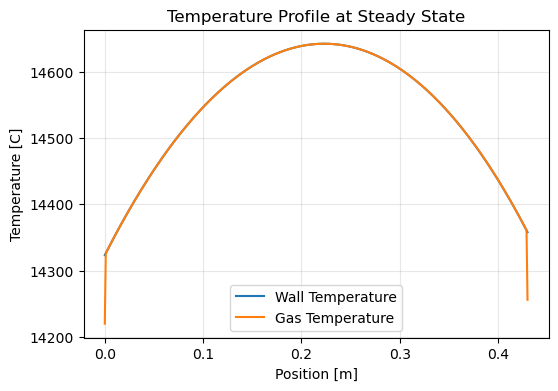

In [168]:
plt.figure(figsize=(6,4))
plt.plot(z, Tw[:,-1], label='Wall Temperature')
plt.plot(z, Tg[:,-1], label='Gas Temperature')
plt.xlabel('Position [m]')
plt.ylabel('Temperature [C]')
plt.title('Temperature Profile at Steady State')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Computing energy balance history...


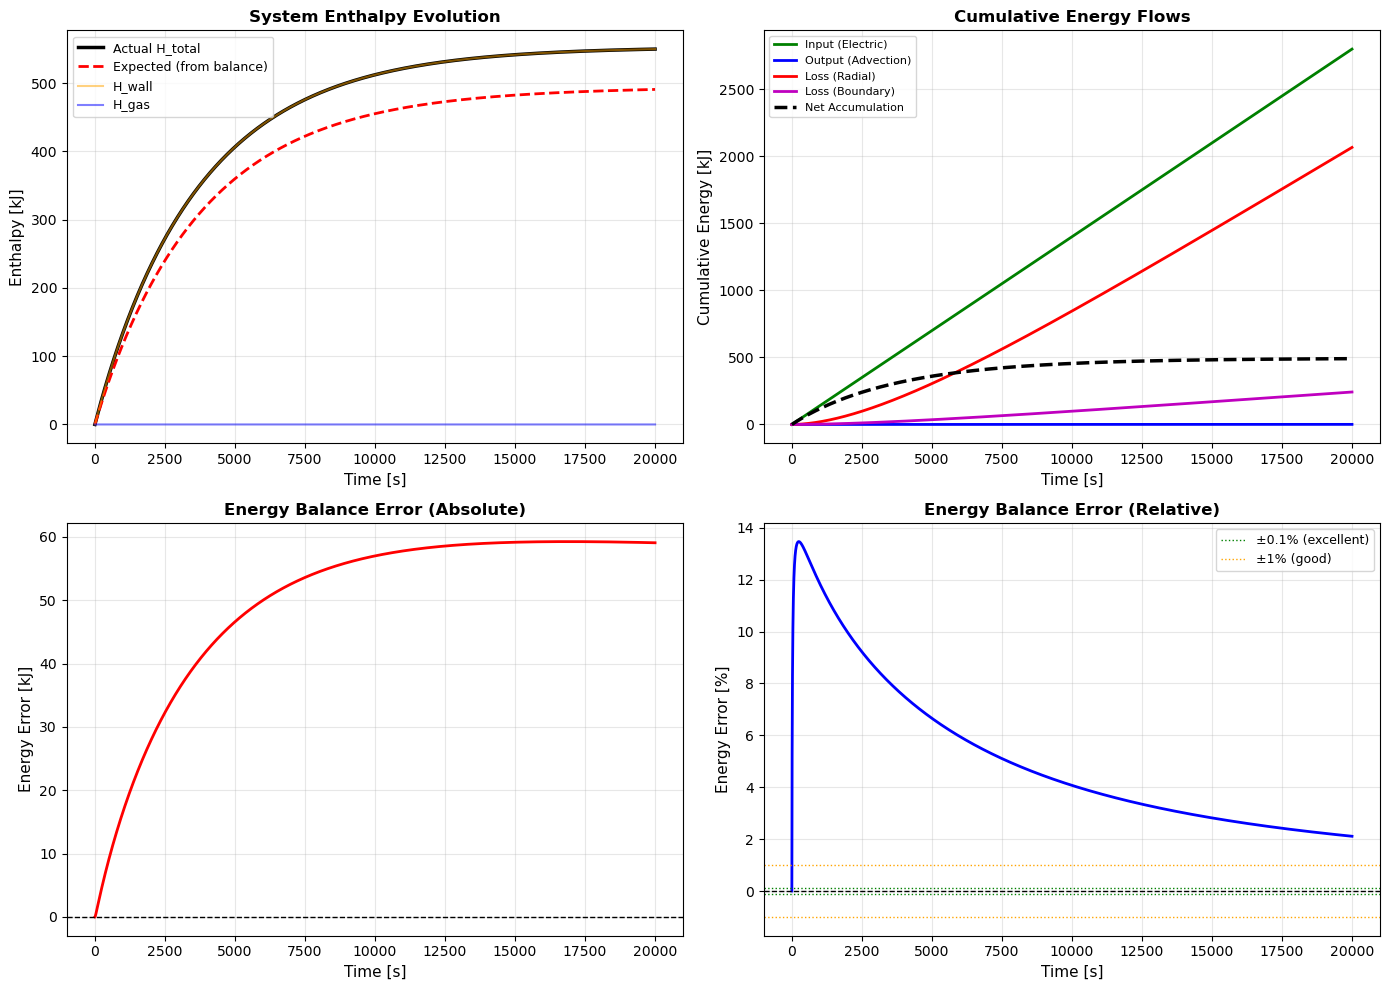


ENERGY BALANCE VALIDATION SUMMARY
Simulation time: 20000.0 s

Boundary Heat Transfer Coefficients (Optimization Parameters):
  h_wall_inlet:      10.00 W/m2/K (exposed inlet region)
  h_wall_outlet:     10.00 W/m2/K (exposed outlet region)
  h_gas_inlet:       20.00 W/m2/K (gas preheat zone)
  h_gas_outlet:      20.00 W/m2/K (gas post-heat zone)

Final System Enthalpy:
  Wall:        549.83 kJ
  Gas:           0.00 kJ
  Total:       549.83 kJ

Cumulative Energy Flows:
  Input (Electric):             2800.00 kJ
  Output (Advection):              0.61 kJ
  Loss (Radial):                2066.59 kJ
  Loss (Boundary):               242.05 kJ
  Net Accumulation:              490.75 kJ

Energy Balance Check:
  Expected ΔH:                490.75 kJ
  Actual ΔH:                  549.83 kJ
  Error (absolute):          59.0854 kJ
  Error (relative):         2.110191 %
⚠️  ACCEPTABLE: Energy balance error < 5% (numerical error)


In [169]:
# ============================================================
# Energy Balance Validation (Post-Processing)
# ============================================================

from scipy.integrate import cumulative_trapezoid

# Calculate energy fluxes and enthalpy at each time point
n_time = len(sol.t)
Q_in_inst = np.zeros(n_time)
Q_out_advection_inst = np.zeros(n_time)
Q_loss_inst = np.zeros(n_time)
Q_boundary_loss_inst = np.zeros(n_time)
H_wall = np.zeros(n_time)
H_gas = np.zeros(n_time)
H_total = np.zeros(n_time)

print("Computing energy balance history...")
for i in range(n_time):
    Q_in_inst[i], Q_out_advection_inst[i], Q_loss_inst[i], Q_boundary_loss_inst[i] = calculate_energy_fluxes(sol.t[i], sol.y[:, i])
    H_wall[i], H_gas[i], H_total[i] = calculate_system_enthalpy(sol.y[:, i])

# Cumulative energy flows using trapezoidal integration
Q_in_cum = cumulative_trapezoid(Q_in_inst, sol.t, initial=0)
Q_out_advection_cum = cumulative_trapezoid(Q_out_advection_inst, sol.t, initial=0)
Q_loss_cum = cumulative_trapezoid(Q_loss_inst, sol.t, initial=0)
Q_boundary_loss_cum = cumulative_trapezoid(Q_boundary_loss_inst, sol.t, initial=0)

# Expected enthalpy change from energy balance
# dH/dt = Q_in - Q_out_advection - Q_loss - Q_boundary_loss
H_expected = H_total[0] + (Q_in_cum - Q_out_advection_cum - Q_loss_cum - Q_boundary_loss_cum)

# Energy balance error
energy_error = H_total - H_expected
energy_error_pct = (energy_error / (Q_in_cum + 1e-10)) * 100

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: System Enthalpy vs Time
ax1 = axes[0, 0]
ax1.plot(sol.t, H_total/1000, 'k-', linewidth=2.5, label='Actual H_total')
ax1.plot(sol.t, H_expected/1000, 'r--', linewidth=2, label='Expected (from balance)')
ax1.plot(sol.t, H_wall/1000, 'orange', alpha=0.5, linewidth=1.5, label='H_wall')
ax1.plot(sol.t, H_gas/1000, 'blue', alpha=0.5, linewidth=1.5, label='H_gas')
ax1.set_xlabel('Time [s]', fontsize=11)
ax1.set_ylabel('Enthalpy [kJ]', fontsize=11)
ax1.set_title('System Enthalpy Evolution', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Energy Flows
ax2 = axes[0, 1]
ax2.plot(sol.t, Q_in_cum/1000, 'g-', linewidth=2, label='Input (Electric)')
ax2.plot(sol.t, Q_out_advection_cum/1000, 'b-', linewidth=2, label='Output (Advection)')
ax2.plot(sol.t, Q_loss_cum/1000, 'r-', linewidth=2, label='Loss (Radial)')
ax2.plot(sol.t, Q_boundary_loss_cum/1000, 'm-', linewidth=2, label='Loss (Boundary)')
net_accum = Q_in_cum - Q_out_advection_cum - Q_loss_cum - Q_boundary_loss_cum
ax2.plot(sol.t, net_accum/1000, 'k--', linewidth=2.5, label='Net Accumulation')
ax2.set_xlabel('Time [s]', fontsize=11)
ax2.set_ylabel('Cumulative Energy [kJ]', fontsize=11)
ax2.set_title('Cumulative Energy Flows', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8, loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: Energy Balance Error (Absolute)
ax3 = axes[1, 0]
ax3.plot(sol.t, energy_error/1000, 'r-', linewidth=2)
ax3.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax3.set_xlabel('Time [s]', fontsize=11)
ax3.set_ylabel('Energy Error [kJ]', fontsize=11)
ax3.set_title('Energy Balance Error (Absolute)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Energy Balance Error (Percentage)
ax4 = axes[1, 1]
ax4.plot(sol.t, energy_error_pct, 'b-', linewidth=2)
ax4.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax4.axhline(y=0.1, color='green', linestyle=':', linewidth=1, label='±0.1% (excellent)')
ax4.axhline(y=-0.1, color='green', linestyle=':', linewidth=1)
ax4.axhline(y=1, color='orange', linestyle=':', linewidth=1, label='±1% (good)')
ax4.axhline(y=-1, color='orange', linestyle=':', linewidth=1)
ax4.set_xlabel('Time [s]', fontsize=11)
ax4.set_ylabel('Energy Error [%]', fontsize=11)
ax4.set_title('Energy Balance Error (Relative)', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final energy balance summary
print("\n" + "=" * 80)
print("ENERGY BALANCE VALIDATION SUMMARY")
print("=" * 80)
print(f"Simulation time: {sol.t[-1]:.1f} s")
print(f"\nBoundary Heat Transfer Coefficients (Optimization Parameters):")
print(f"  h_wall_inlet:   {h_wall_inlet:>8.2f} W/m2/K (exposed inlet region)")
print(f"  h_wall_outlet:  {h_wall_outlet:>8.2f} W/m2/K (exposed outlet region)")
print(f"  h_gas_inlet:    {h_gas_inlet:>8.2f} W/m2/K (gas preheat zone)")
print(f"  h_gas_outlet:   {h_gas_outlet:>8.2f} W/m2/K (gas post-heat zone)")
print(f"\nFinal System Enthalpy:")
print(f"  Wall:  {H_wall[-1]/1000:>12.2f} kJ")
print(f"  Gas:   {H_gas[-1]/1000:>12.2f} kJ")
print(f"  Total: {H_total[-1]/1000:>12.2f} kJ")
print(f"\nCumulative Energy Flows:")
print(f"  Input (Electric):        {Q_in_cum[-1]/1000:>12.2f} kJ")
print(f"  Output (Advection):      {Q_out_advection_cum[-1]/1000:>12.2f} kJ")
print(f"  Loss (Radial):           {Q_loss_cum[-1]/1000:>12.2f} kJ")
print(f"  Loss (Boundary):         {Q_boundary_loss_cum[-1]/1000:>12.2f} kJ")
print(f"  Net Accumulation:        {net_accum[-1]/1000:>12.2f} kJ")
print(f"\nEnergy Balance Check:")
print(f"  Expected ΔH:          {(H_expected[-1] - H_total[0])/1000:>12.2f} kJ")
print(f"  Actual ΔH:            {(H_total[-1] - H_total[0])/1000:>12.2f} kJ")
print(f"  Error (absolute):     {energy_error[-1]/1000:>12.4f} kJ")
print(f"  Error (relative):     {energy_error_pct[-1]:>12.6f} %")
print("=" * 80)
if abs(energy_error_pct[-1]) < 0.1:
    print("✅ EXCELLENT: Energy balance error < 0.1%")
elif abs(energy_error_pct[-1]) < 1.0:
    print("✅ GOOD: Energy balance error < 1%")
elif abs(energy_error_pct[-1]) < 5.0:
    print("⚠️  ACCEPTABLE: Energy balance error < 5% (numerical error)")
else:
    print("❌ WARNING: Energy balance error >= 5% (check model)")
print("=" * 80)

In [170]:
Tg

array([[   25.        ,    32.03089527,    38.94602946, ...,
        14219.60436338, 14219.62369594, 14219.64302359],
       [   25.        ,    32.94605562,    40.75203353, ...,
        14324.68884609, 14324.70818647, 14324.72752195],
       [   25.        ,    33.18123608,    41.21841798, ...,
        14329.01912434, 14329.03846329, 14329.05779734],
       ...,
       [   25.        ,    33.26385647,    41.38913855, ...,
        14363.73432731, 14363.75362743, 14363.77292265],
       [   25.        ,    33.25884567,    41.37327509, ...,
        14360.88855686, 14360.90785672, 14360.92715168],
       [   25.        ,    32.30800226,    39.49746102, ...,
        14255.79134595, 14255.81063805, 14255.82992527]],
      shape=(431, 20001))